# GoShifter Calderon et al.

**Created**: 28 March 2022

I ran my version of GoShifter on the following set of SNPs. In all cases, I included the lead SNP and any tagging SNPs ($R^2 > 0.8$).

1. Lead eSNPs from Initial cis-eQTL Mapping
2. Conditional eSNPs from cis-eQTL Mapping
3. Conditional eSNPs that represent non-primary signals from the cis-eQTL Mapping
3. Lead eSNPs that are sepsis-specific based on Katie's mashR analysis
4. Lead eSNPs that are sepsis-specific and stronger in GAInS based on Katie's mashR analysis
5. Lead eSNPs that are NOT sepsis-specific based on Katie's mashR analysis

## Environment

In [4]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

Loading required namespace: patchwork



In [5]:
library(tidyverse)
library(patchwork)
library(ComplexHeatmap)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    betwee

## Specific Stimulations

### Load Data

In [6]:
lineages <- read.csv("03_Functional_Interpretation/data/Calderon_et_al_lineages.csv")

In [7]:
head(lineages)

,Lineage,Cell_Type
,<chr>,<chr>
1,B,Bulk_B
2,B,Mem_B
3,B,Naive_B
4,B,Plasmoblasts
5,CD8,CD8pos_T
6,CD8,Central_memory_CD8pos_T


**NOTE**: I created these p-value tables by merging results from the GoShifter NextFlow pipeline on the command line.

In [8]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/go_shifter/lead_snps_p_values.tsv", sep="\t", col.names=c("Cell_Type", "P_Value"))
cond.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/go_shifter/conditional_snps_p_values.tsv", sep="\t", col.names=c("Cell_Type", "P_Value"))
cond.only.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/go_shifter/conditional_secondary_snps_p_values.tsv", sep="\t", col.names=c("Cell_Type", "P_Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/go_shifter/non_sepsis_snps_p_values.tsv", sep="\t", col.names=c("Cell_Type", "P_Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/go_shifter/sepsis_snps_p_values.tsv", sep="\t", col.names=c("Cell_Type", "P_Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/enrichment/go_shifter/sepsis_up_snps_p_values.tsv", sep="\t", col.names=c("Cell_Type", "P_Value"))

In [9]:
go.shifter <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    cond.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    cond.only.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
) %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL")))

In [10]:
head(go.shifter)

,Cell_Type,P_Value,SNPs
,<chr>,<dbl>,<fct>
1,Bulk_B,0.9639,Lead cis-eQTL
2,CD8pos_T,0.2751,Lead cis-eQTL
3,Central_memory_CD8pos_T,0.0040,Lead cis-eQTL
4,Effector_CD4pos_T,0.1582,Lead cis-eQTL
5,Effector_memory_CD8pos_T,0.6250,Lead cis-eQTL
6,Follicular_T_Helper,0.4131,Lead cis-eQTL


The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`) and the number of SNP lists tested (6).

In [11]:
p.val.threshold <- 0.05 / (nrow(lead.p.vals) * 6)

### Enrichment of Different SNP Lists

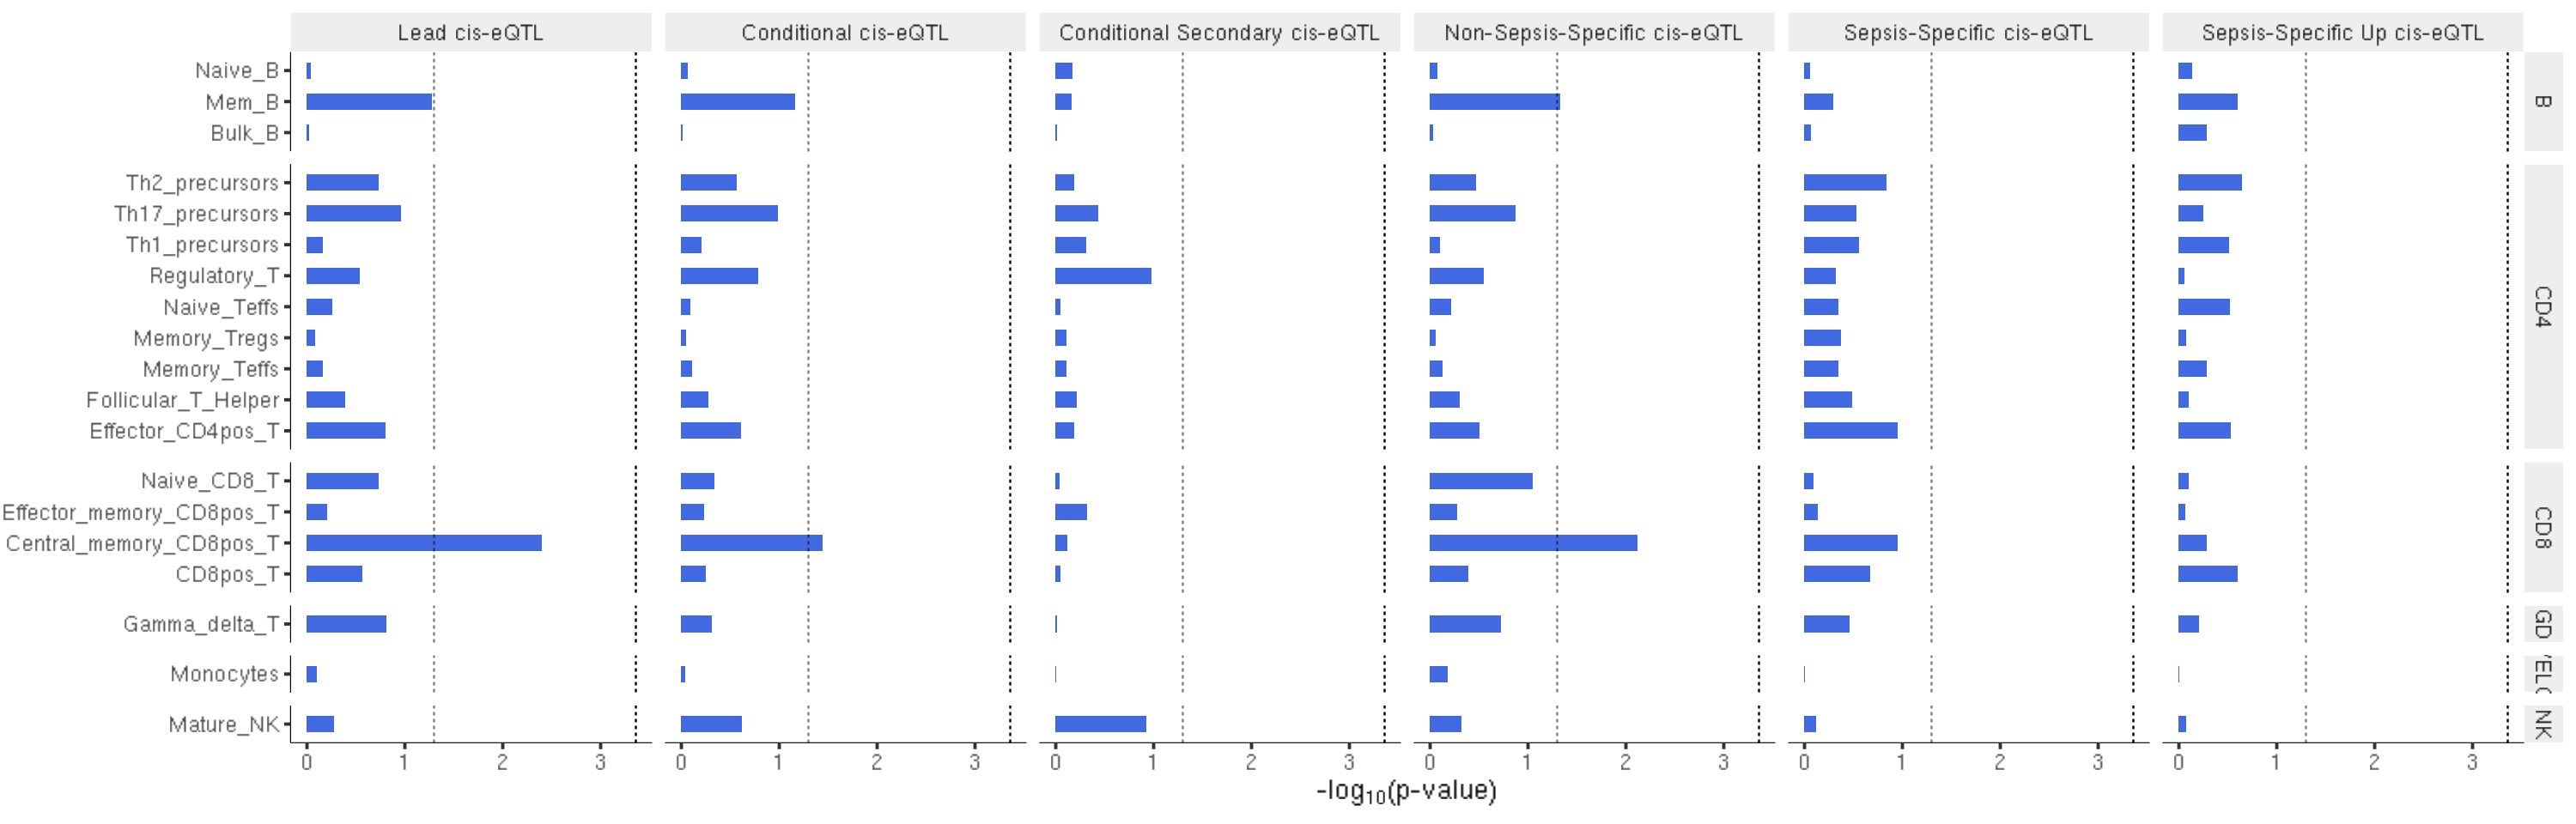

In [12]:
options(repr.plot.width=25, repr.plot.height=8)

go.shifter %>%
    merge(., lineages, by="Cell_Type") %>%
    dplyr::mutate(LogP=-log10(P_Value)) %>%
    ggplot() +
    geom_bar(aes(x=Cell_Type, y=LogP), stat="identity", fill="royalblue", width=0.5) +
    geom_hline(aes(yintercept=-log10(0.05)), lty=2, alpha=0.5) +
    geom_hline(aes(yintercept=-log10(p.val.threshold)), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab(bquote("-log"[10]*"(p-value)")) +
    ggplot_theme +
    theme(axis.title.y=element_blank())

ggsave("03_Functional_Interpretation/results/go_shifter_calderon_et_al_all.svg", width=25, height=8)

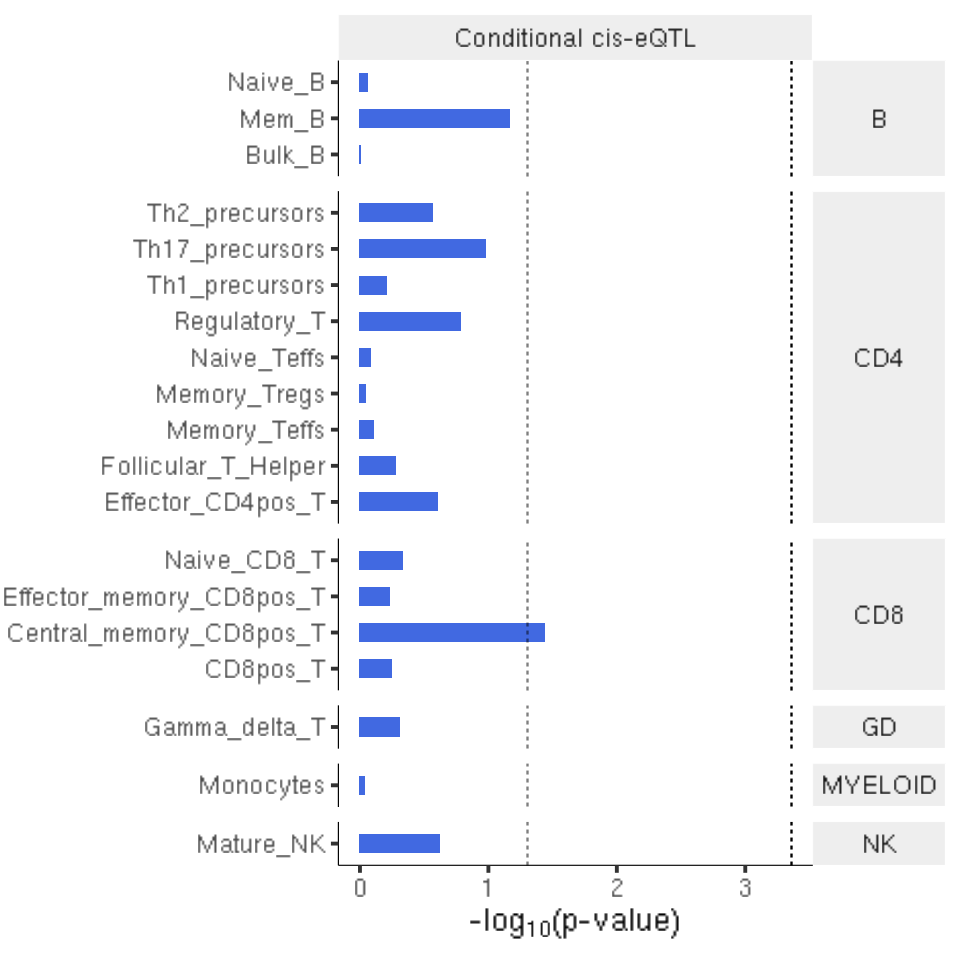

In [17]:
options(repr.plot.width=8, repr.plot.height=8)

go.shifter %>%
    merge(., lineages, by="Cell_Type") %>%
    dplyr::mutate(LogP=-log10(P_Value)) %>%
    dplyr::filter(SNPs == "Conditional cis-eQTL") %>%
    ggplot() +
    geom_bar(aes(x=Cell_Type, y=LogP), stat="identity", fill="royalblue", width=0.5) +
    geom_hline(aes(yintercept=-log10(0.05)), lty=2, alpha=0.5) +
    geom_hline(aes(yintercept=-log10(p.val.threshold)), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab(bquote("-log"[10]*"(p-value)")) +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/go_shifter_calderon_et_al_conditional.svg", width=8, height=8)